/tmp/ipykernel_1613380/2716659961.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755898319/work/torch/csrc/utils/tensor_new.cpp:210.)
  states = torch.Tensor(batch.state)


Episode 0	Last reward: 4.719474110893663	Average reward 14.75
Episode 10	Last reward: 213.93408042178245	Average reward 210.38
Episode 20	Last reward: 253.74790291100865	Average reward 264.62
Episode 30	Last reward: 325.00440352660524	Average reward 336.68
Episode 40	Last reward: 657.6298469399675	Average reward 525.69
Episode 50	Last reward: 672.3825107179298	Average reward 880.80
Episode 60	Last reward: 1958.7521932319787	Average reward 1457.26
Episode 70	Last reward: 2184.2883173506016	Average reward 1279.82
Episode 80	Last reward: 2874.495464865169	Average reward 1651.25
Episode 90	Last reward: 1901.5712562378485	Average reward 2111.92
Episode 100	Last reward: 2681.9949399162406	Average reward 1495.03
Episode 110	Last reward: 2867.378334680997	Average reward 1675.63
Episode 120	Last reward: 1464.979684411858	Average reward 1872.56
Episode 130	Last reward: 2780.947644954287	Average reward 2670.63
Episode 140	Last reward: 654.0739470750169	Average reward 1867.27
Episode 150	Last rewa

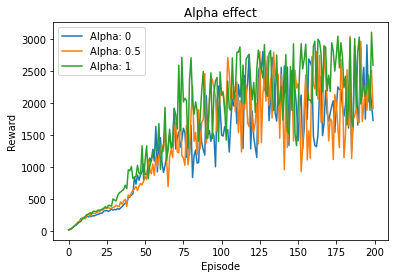

In [1]:
import argparse
from itertools import count

import gym
import scipy.optimize

import torch
from models import *
from replay_memory import Memory
from running_state import ZFilter
from torch.autograd import Variable
from trpo import trpo_step
from utils import *
from time import time
import matplotlib.pyplot as plt

torch.utils.backcompat.broadcast_warning.enabled = True
torch.utils.backcompat.keepdim_warning.enabled = True

torch.set_default_tensor_type('torch.DoubleTensor')

###Options
env_name = 'Hopper-v3' #''Hopper-v3'
seed = 1
gamma = 0.995
tau = 0.97
l2_reg = 1e-3
max_kl = 1e-2
damping = 1e-1
batch_size = 2000
log_interval = 10
alpha = 0.5
render = False

env = gym.make(env_name)

num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

#env.seed(seed)
torch.manual_seed(seed)

policy_net = Policy(num_inputs, num_actions)
value_net = Value(num_inputs)

def select_action(state):
    state = torch.from_numpy(state).unsqueeze(0)
    action_mean, _, action_std = policy_net(Variable(state))
    action = torch.normal(action_mean, action_std)
    return action

def update_params(batch):
    rewards = torch.Tensor(batch.reward)
    masks = torch.Tensor(batch.mask)
    actions = torch.Tensor(np.concatenate(batch.action, 0))
    states = torch.Tensor(batch.state)
    values = value_net(Variable(states))

    returns = torch.Tensor(actions.size(0),1)
    deltas = torch.Tensor(actions.size(0),1)
    advantages = torch.Tensor(actions.size(0),1)

    prev_return = 0
    prev_value = 0
    prev_advantage = 0
    for i in reversed(range(rewards.size(0))):
        returns[i] = rewards[i] + gamma * prev_return * masks[i]
        deltas[i] = rewards[i] + gamma * prev_value * masks[i] - values.data[i]
        advantages[i] = deltas[i] + gamma * tau * prev_advantage * masks[i]

        prev_return = returns[i, 0]
        prev_value = values.data[i, 0]
        prev_advantage = advantages[i, 0]

    targets = Variable(returns)

    # Original code uses the same LBFGS to optimize the value loss
    def get_value_loss(flat_params):
        set_flat_params_to(value_net, torch.Tensor(flat_params))
        for param in value_net.parameters():
            if param.grad is not None:
                param.grad.data.fill_(0)

        values_ = value_net(Variable(states))

        value_loss = (values_ - targets).pow(2).mean()

        # weight decay
        for param in value_net.parameters():
            value_loss += param.pow(2).sum() * l2_reg
        value_loss.backward()
        return (value_loss.data.double().numpy(), get_flat_grad_from(value_net).data.double().numpy())

    flat_params, _, opt_info = scipy.optimize.fmin_l_bfgs_b(get_value_loss, get_flat_params_from(value_net).double().numpy(), maxiter=25)
    set_flat_params_to(value_net, torch.Tensor(flat_params))

    advantages = (advantages - advantages.mean()) / advantages.std()

    action_means, action_log_stds, action_stds = policy_net(Variable(states))
    fixed_log_prob = normal_log_density(Variable(actions), action_means, action_log_stds, action_stds).data.clone()

    def get_loss(volatile=False):
        if volatile:
            with torch.no_grad():
                action_means, action_log_stds, action_stds = policy_net(Variable(states))
        else:
            action_means, action_log_stds, action_stds = policy_net(Variable(states))
                
        log_prob = normal_log_density(Variable(actions), action_means, action_log_stds, action_stds)
        action_loss = -Variable(advantages) * torch.exp(log_prob - Variable(fixed_log_prob))
        return action_loss.mean()


    def get_kl():
        mean1, log_std1, std1 = policy_net(Variable(states))

        mean0 = Variable(mean1.data)
        log_std0 = Variable(log_std1.data)
        std0 = Variable(std1.data)
        kl = log_std1 - log_std0 + (std0.pow(2) + (mean0 - mean1).pow(2)) / (2.0 * std1.pow(2)) - 0.5
        return kl.sum(1, keepdim=True)

    trpo_step(policy_net, get_loss, get_kl, max_kl, damping, alpha)

running_state = ZFilter((num_inputs,), clip=5)
running_reward = ZFilter((1,), demean=False, clip=10)

#print('observation_space.high: ', env.observation_space.high)
#print('observation_space low: ', env.observation_space.low)
#print('action_space: ', env.action_space)
for alpha in [0, 0.5, 1]:
    time_0 = time()
    rewards_plot = []
    policy_net = Policy(num_inputs, num_actions)
    value_net = Value(num_inputs)
    running_state = ZFilter((num_inputs,), clip=5)
    running_reward = ZFilter((1,), demean=False, clip=10)


    for i_episode in range(200):
        memory = Memory()
        #print(i_episode)
        frames = []




        num_steps = 0
        reward_batch = 0
        num_episodes = 0
        while num_steps < batch_size:
            state = env.reset(seed=seed)
            state = running_state(state)

            reward_sum = 0
            for t in range(10000): # Don't infinite loop while learning
                action = select_action(state)
                action = action.data[0].numpy()
                next_state, reward, done, _ = env.step(action)
                reward_sum += reward

                next_state = running_state(next_state)

                mask = 1

                if done:
                    mask = 0

                memory.push(state, np.array([action]), mask, next_state, reward)
                #if i_episode %10 ==0:
                if render:
                        #env.render()
                        frames.append(env.render())

                       # env = gym.wrappers.RecordVideo(env, './videos/' + str(time()) + '/')

                if done:
                    break

                state = next_state
            num_steps += (t-1)
            num_episodes += 1
            reward_batch += reward_sum

        reward_batch /= num_episodes
        batch = memory.sample()
        update_params(batch)
        #print(frames)
      # save_frames_as_gif(frames)

        if i_episode % log_interval == 0:
            print('Episode {}\tLast reward: {}\tAverage reward {:.2f}'.format(
                i_episode, reward_sum, reward_batch))
        rewards_plot.append(reward_batch)

    plt.title('Alpha effect')
    plt.plot(rewards_plot, label = 'Alpha: ' + str(alpha))
    time_1 = time()
    print()
    print('----------------')
    print(env_name, 'time: ', time_1-time_0)

plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend()
plt.show()

In [2]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)